In [1]:
import numpy as np
import pandas as pd
import matplotlib.pylab as plt
%matplotlib inline
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 10,6

pd.options.display.float_format = '{:.5f}'.format

In [2]:
dataset = pd.read_csv("USCarrier_Traffic_20200602120518.csv", index_col='Period',parse_dates=True,infer_datetime_format=True)

In [3]:
dataset.head()

,Total
Period,
2000-01-01,49045412
2000-02-01,49306303
2000-03-01,60443541
2000-04-01,58286680
2000-05-01,60533783


In [4]:
data = dataset['2019-01-01':'2019-12-01']
data = dataset['2019']

C:\Users\DELL\Anaconda3\lib\site-packages\pandas\plotting\_matplotlib\converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


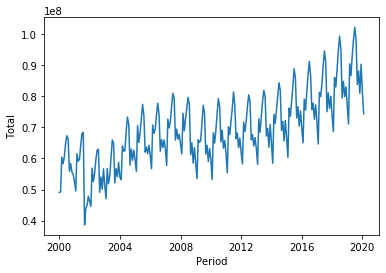

In [5]:
plt.plot(dataset)
#plt.plot(data)
plt.xlabel("Period")
plt.ylabel("Total")
plt.show()

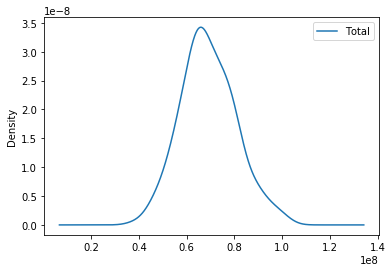

In [6]:
dataset.plot(kind='kde')

##### Here we conclude that our data is seasonal but we can see that there is some trend also involved in the data.

##### Now creating a method to check the whether our data is stationary or not.

In [7]:
#creating a function for checking data whether it is stationary or not.
from statsmodels.tsa.stattools import adfuller
def check_stationary(timeSeries):
    
    rolMean = timeSeries.rolling(window = 12).mean()
    rolstd = timeSeries.rolling(window = 12).std()
    
    plt.subplot(111)
    plt.plot(timeSeries, label = 'Original')
    plt.plot(rolMean, label = 'Rolling mean')
    plt.plot(rolstd, label = 'Rolling STD')
    plt.legend(loc='best')
    plt.show()
    
    dftest = adfuller(timeSeries,autolag='AIC')

    dfoutput = pd.Series(dftest[:4],index = ["Test Statistic","P-Value","No of Lags","No of obs"])
    for key, value in dftest[4].items():
        dfoutput['Critical value %s'%key] = value
        
    print(dfoutput)

##### Here we can also see that rolling mean for window 1 and we can infer that mean is not constant for the monthly comparison.

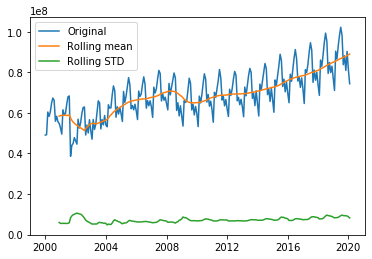

Test Statistic         0.22322
P-Value                0.97353
No of Lags            13.00000
No of obs            228.00000
Critical value 1%     -3.45936
Critical value 5%     -2.87430
Critical value 10%    -2.57357
dtype: float64


In [8]:
check_stationary(dataset)
#check_stationary(data)

##### In above graph we can see that the mean and std is not constant. I.e the data is not stationary.

##### Also we can see that p-value is also higher

##### And test-statistic is greater then the critical value.

In [9]:
datasetShiftting = dataset - dataset.shift(1)

In [10]:
datasetShiftting.dropna(inplace=True)

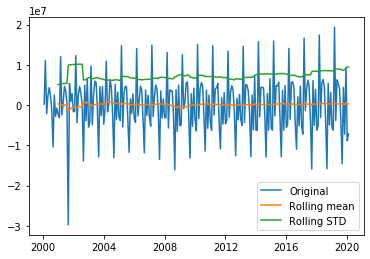

Test Statistic        -3.95932
P-Value                0.00164
No of Lags            12.00000
No of obs            228.00000
Critical value 1%     -3.45936
Critical value 5%     -2.87430
Critical value 10%    -2.57357
dtype: float64


In [11]:
check_stationary(datasetShiftting)

###### Here, visually we can see that there is no trend is present and we have constant mean and std
##### Also the Test Statistic is less than the critical value and we can also see the P-value is smalller

##### so we can conclude that our time series is stationary.

### Now we will check the components of the time series

##### The additive additive model is useful useful when thethe seasonal variation is  relatively constant over time

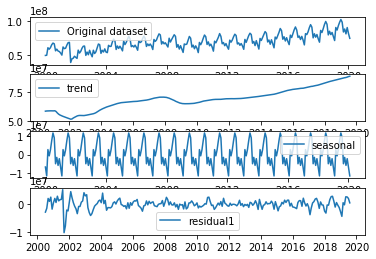

In [12]:
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(dataset,model='additive')
#decomposition = seasonal_decompose(datasetShiftting,model='Mul')

# Here we have 3 components
trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

# plot the components
plt.subplot(411)
plt.plot(dataset, label = 'Original dataset')
plt.legend(loc = 'best')

plt.subplot(412)
plt.plot(trend, label = 'trend')
plt.legend(loc = 'best')

plt.subplot(413)
plt.plot(seasonal, label = 'seasonal')
plt.legend(loc = 'best')

plt.subplot(414)
plt.plot(residual, label = 'residual1')
plt.legend(loc = 'best')


plt.show()

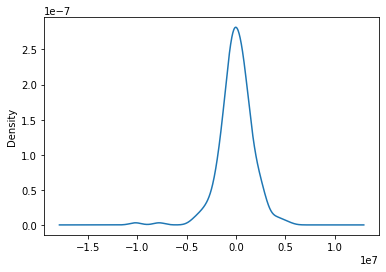

In [13]:
# ploting residual
residual.plot(kind='kde')
plt.show()

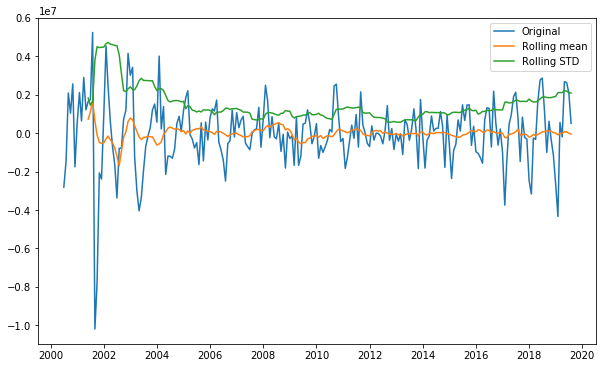

Test Statistic        -5.95793
P-Value                0.00000
No of Lags            14.00000
No of obs            215.00000
Critical value 1%     -3.46114
Critical value 5%     -2.87508
Critical value 10%    -2.57399
dtype: float64


In [41]:
# now check if the noise stationary or not
decomposedResiducal = residual
decomposedResiducal.dropna(inplace=True)
check_stationary(decomposedResiducal)

# here we can see that noise is stationary but there is some fluctuations in the data.
# this is why we need to have moving average parameter in place so that it smoothens it out to predict what will happen next
# now we know the value is d = 1 i.e. we have shifted only once.


##### now deciding value of p and q i.e auto regressive lags and value of moving average
##### plot ACF and PCAF graph repectively for p and q i.e for auto regressive lags and value of moving average

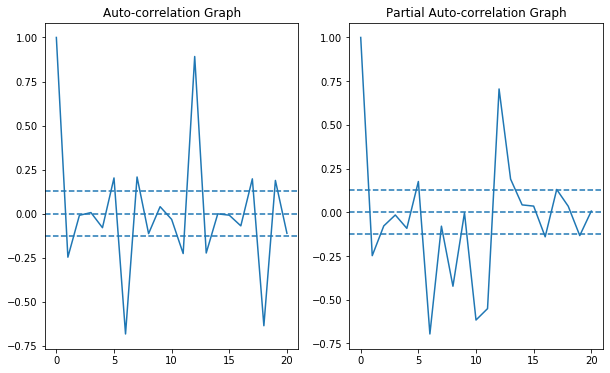

In [47]:
from statsmodels.tsa.stattools import acf,pacf

lag_acf = acf(datasetShiftting, nlags= 20)
lag_pacf = pacf(datasetShiftting, nlags= 20, method = 'ols') # we usually prefer ols ordinary least method

plt.subplot(121)
plt.plot(lag_acf)
plt.axhline( y = 0, linestyle = '--')
plt.axhline( y = -1.96/np.sqrt(len(datasetShiftting)), linestyle = '--')
plt.axhline( y = 1.96/np.sqrt(len(datasetShiftting)), linestyle = '--')
plt.title("Auto-correlation Graph")

plt.subplot(122)
plt.plot(lag_pacf)
plt.axhline( y = 0, linestyle = '--')
plt.axhline( y = -1.96/np.sqrt(len(datasetShiftting)), linestyle = '--')
plt.axhline( y = 1.96/np.sqrt(len(datasetShiftting)), linestyle = '--')
plt.title("Partial Auto-correlation Graph")

plt.show()

##### using above and below graph we can conclude that our p =1 and d=1

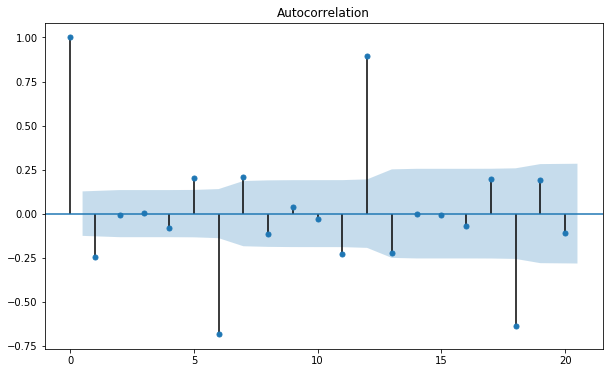

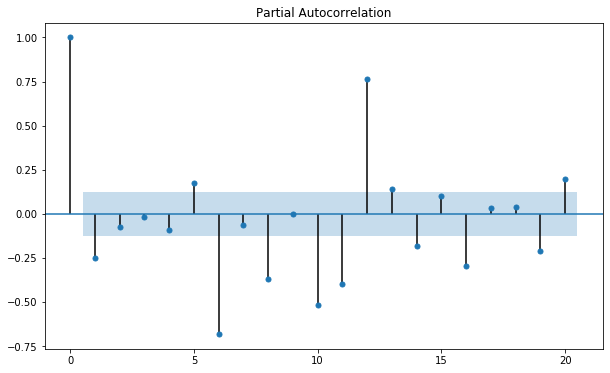

In [48]:
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf

plot_acf(datasetShiftting['Total'].dropna(),lags=20)
plot_pacf(datasetShiftting['Total'].dropna(),lags=20)
plt.show()

## Now creating the SARIMA model
##### During the seasonal decompose analysis we can able to see that there is no any trend present in the data. and theh daata is seasonal. SO now applying SARIMA i.e. Seasonal Arima

In [17]:
import statsmodels.api as sm

##### fitting a model using visualised values

In [18]:
visualModel = sm.tsa.statespace.SARIMAX(dataset,order = (1,1,1),seasonal_order = (1,1,1,12))

C:\Users\DELL\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\DELL\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


In [19]:
visualresult = visualModel.fit()

In [20]:
dataset.shape

(242, 1)

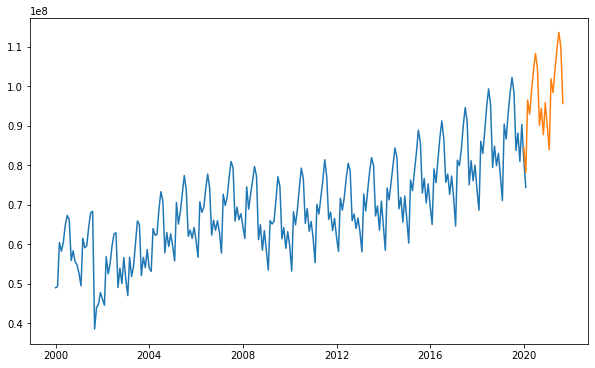

In [49]:
visualforecast = visualresult.predict(start=240,end =260,dynamic=True)
plt.plot(dataset.Total)
plt.plot(visualforecast)

##### pip install pmdarima

In [22]:
# just for reference used shifting model, will not be using this model
# do not use this model
from pmdarima import auto_arima
autoShiftModel = auto_arima(datasetShiftting, start_p=1, start_q=1,max_p=3, max_q=3, m=12,
                           start_P=1,start_Q=1,max_P=2,max_Q=3,
                           seasonal=True,information_criterion='aic',alpha=0.05,
                           d=1, D=1, trace=True,
                           error_action='ignore',  
                           suppress_warnings=True, 
                           stepwise=True
                          )
autoShiftResult = autoShiftModel.fit(datasetShiftting)

Performing stepwise search to minimize aic
Fit ARIMA(1,1,1)x(1,1,1,12) [intercept=True]; AIC=7333.857, BIC=7354.433, Time=0.945 seconds
Fit ARIMA(0,1,0)x(0,1,0,12) [intercept=True]; AIC=7560.713, BIC=7567.572, Time=0.028 seconds
Fit ARIMA(1,1,0)x(1,1,0,12) [intercept=True]; AIC=7457.341, BIC=7471.059, Time=0.368 seconds
Fit ARIMA(0,1,1)x(0,1,1,12) [intercept=True]; AIC=7349.744, BIC=7363.461, Time=0.548 seconds
Fit ARIMA(0,1,0)x(0,1,0,12) [intercept=False]; AIC=7559.072, BIC=7562.501, Time=0.021 seconds
Fit ARIMA(1,1,1)x(0,1,1,12) [intercept=True]; AIC=7334.450, BIC=7351.596, Time=0.713 seconds
Fit ARIMA(1,1,1)x(1,1,0,12) [intercept=True]; AIC=7342.417, BIC=7359.564, Time=0.547 seconds
Fit ARIMA(1,1,1)x(2,1,1,12) [intercept=True]; AIC=7326.044, BIC=7350.049, Time=2.570 seconds
Fit ARIMA(1,1,1)x(2,1,0,12) [intercept=True]; AIC=7327.715, BIC=7348.291, Time=1.658 seconds
Fit ARIMA(1,1,1)x(2,1,2,12) [intercept=True]; AIC=7328.007, BIC=7355.441, Time=4.089 seconds
Fit ARIMA(1,1,1)x(1,1,2,12

In [23]:
autoShiftResult.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                                  y   No. Observations:                  241
Model:             SARIMAX(3, 1, 2)x(2, 1, 2, 12)   Log Likelihood               -3637.523
Date:                            Wed, 10 Jun 2020   AIC                           7297.046
Time:                                    23:39:34   BIC                           7334.769
Sample:                                         0   HQIC                          7312.266
                                            - 241                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept  -6762.6752   7301.803     -0.926      0.354   -2.11e+04    7548.596
ar.L1         -0.7358      0.539     -1.364      0.172      -1.793       0.321
ar.L2         -0.3594      0.171     -2.096      0.036      -0.695      -0.023
ar.L3         -0.2007      0.097     -2.066      0.039      -0.391      -0.010
ma.L1         -0.5667      0.544     -1.042      0.298      -1.633       0.500
ma.L2         -0.3616      0.538     -0.673      0.501      -1.415       0.692
ar.S.L12       0.7972      0.132      6.031      0.000       0.538       1.056
ar.S.L24      -0.5445      0.056     -9.725      0.000      -0.654      -0.435
ma.S.L12      -1.3852      0.149     -9.327      0.000      -1.676      -1.094
ma.S.L24       0.7407      0.141      5.267      0.000       0.465       1.016
sigma2      4.795e+12   2.28e-05    2.1e+17      0.000     4.8e+12     4.8e+12
===================================================================================
Ljung-Box (Q):                       39.89   Jarque-Bera (JB):              8741.45
Prob(Q):                              0.48   Prob(JB):                         0.00
Heteroskedasticity (H):               0.20   Skew:                            -3.29
Prob(H) (two-sided):                  0.00   Kurtosis:                        32.61
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 1.48e+33. Standard errors may be unstable.
"""

C:\Users\DELL\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\DELL\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\DELL\Anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:963: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\DELL\Anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:975: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


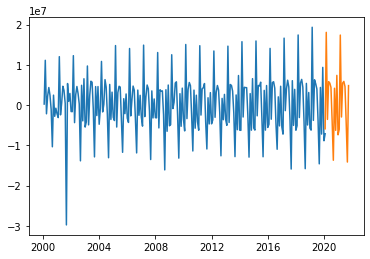

In [24]:
shift_model = sm.tsa.statespace.SARIMAX(datasetShiftting.Total,order = (3,1,2),seasonal_order = (2,1,2,12))
shift_result = shift_model.fit()

shift_forecast = shift_result.predict(start=240,end =260,dynamic=True)
plt.plot(datasetShiftting.Total)
plt.plot(shift_forecast)
plt.show()

In [25]:
shift_result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                              Total   No. Observations:                  241
Model:             SARIMAX(3, 1, 2)x(2, 1, 2, 12)   Log Likelihood               -3635.741
Date:                            Wed, 10 Jun 2020   AIC                           7291.482
Time:                                    23:39:44   BIC                           7325.775
Sample:                                02-01-2000   HQIC                          7305.318
                                     - 02-01-2020                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -1.3103      0.093    -14.098      0.000      -1.492      -1.128
ar.L2         -0.4927      0.135     -3.660      0.000      -0.757      -0.229
ar.L3         -0.1629      0.098     -1.661      0.097      -0.355       0.029
ma.L1         -0.0071      0.113     -0.063      0.950      -0.228       0.214
ma.L2         -0.9929      0.096    -10.319      0.000      -1.181      -0.804
ar.S.L12       0.8375      0.141      5.926      0.000       0.560       1.114
ar.S.L24      -0.5304      0.068     -7.813      0.000      -0.663      -0.397
ma.S.L12      -1.3896      0.166     -8.394      0.000      -1.714      -1.065
ma.S.L24       0.7274      0.150      4.839      0.000       0.433       1.022
sigma2      4.794e+12   3.67e-14   1.31e+26      0.000    4.79e+12    4.79e+12
===================================================================================
Ljung-Box (Q):                       35.54   Jarque-Bera (JB):              9651.70
Prob(Q):                              0.67   Prob(JB):                         0.00
Heteroskedasticity (H):               0.20   Skew:                            -3.33
Prob(H) (two-sided):                  0.00   Kurtosis:                        34.17
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number  2e+41. Standard errors may be unstable.
"""

In [26]:
# predictions has to be done here

In [27]:
#train = dataset[:int(0.7*(len(dataset)))]
#valid = dataset[int(0.7*(len(dataset))):]

In [28]:
model = auto_arima(dataset,start_p=1, start_q=1,max_p=3, max_q=3, m=12,
                           start_P=1,start_Q=1,max_P=2,max_Q=3,
                           seasonal=True,information_criterion='aic',alpha=0.05,
                           d=1, D=1, trace=True,
                           error_action='ignore',  
                           suppress_warnings=True, 
                           stepwise=True)
model.fit(dataset)

Performing stepwise search to minimize aic
Fit ARIMA(1,1,1)x(1,1,1,12) [intercept=True]; AIC=7367.448, BIC=7388.051, Time=2.050 seconds
Fit ARIMA(0,1,0)x(0,1,0,12) [intercept=True]; AIC=7381.347, BIC=7388.214, Time=0.033 seconds
Fit ARIMA(1,1,0)x(1,1,0,12) [intercept=True]; AIC=7378.001, BIC=7391.736, Time=0.359 seconds
Fit ARIMA(0,1,1)x(0,1,1,12) [intercept=True]; AIC=7376.629, BIC=7390.364, Time=0.518 seconds
Fit ARIMA(0,1,0)x(0,1,0,12) [intercept=False]; AIC=7379.702, BIC=7383.136, Time=0.020 seconds
Fit ARIMA(1,1,1)x(0,1,1,12) [intercept=True]; AIC=7377.881, BIC=7395.049, Time=1.056 seconds
Fit ARIMA(1,1,1)x(1,1,0,12) [intercept=True]; AIC=7379.229, BIC=7396.398, Time=0.695 seconds
Fit ARIMA(1,1,1)x(2,1,1,12) [intercept=True]; AIC=7368.228, BIC=7392.264, Time=3.465 seconds
Fit ARIMA(1,1,1)x(1,1,2,12) [intercept=True]; AIC=7368.432, BIC=7392.468, Time=4.307 seconds
Fit ARIMA(1,1,1)x(0,1,0,12) [intercept=True]; AIC=7384.504, BIC=7398.239, Time=0.556 seconds
Fit ARIMA(1,1,1)x(0,1,2,12

ARIMA(order=(0, 1, 1), seasonal_order=(1, 1, 1, 12), suppress_warnings=True)

In [29]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                                  y   No. Observations:                  242
Model:             SARIMAX(0, 1, 1)x(1, 1, 1, 12)   Log Likelihood               -3677.962
Date:                            Wed, 10 Jun 2020   AIC                           7365.925
Time:                                    23:40:27   BIC                           7383.093
Sample:                                         0   HQIC                          7372.851
                                            - 242                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept   1.734e+04   5.21e+04      0.333      0.739   -8.48e+04    1.19e+05
ma.L1         -0.0815      0.019     -4.323      0.000      -0.118      -0.045
ar.S.L12       0.5236      0.072      7.311      0.000       0.383       0.664
ma.S.L12      -0.7621      0.081     -9.410      0.000      -0.921      -0.603
sigma2      5.258e+12      0.005   1.06e+15      0.000    5.26e+12    5.26e+12
===================================================================================
Ljung-Box (Q):                       71.24   Jarque-Bera (JB):              8968.86
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               0.20   Skew:                            -2.88
Prob(H) (two-sided):                  0.00   Kurtosis:                        33.11
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 8.01e+29. Standard errors may be unstable.
"""

C:\Users\DELL\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\DELL\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


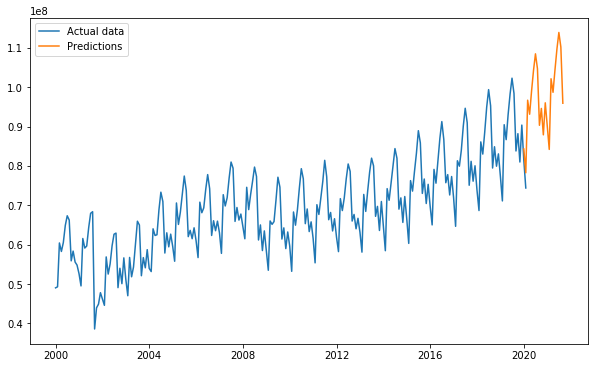

In [50]:
model = sm.tsa.statespace.SARIMAX(dataset.Total,order = (0,1,1),seasonal_order = (1,1,1,12))
result = model.fit()

forecast = result.predict(start=240,end =260,dynamic=True)
plt.plot(dataset.Total,label='Actual data')
plt.plot(forecast,label='Predictions')
plt.legend(loc='best')
plt.show()

In [31]:
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                              Total   No. Observations:                  242
Model:             SARIMAX(0, 1, 1)x(1, 1, 1, 12)   Log Likelihood               -3677.629
Date:                            Wed, 10 Jun 2020   AIC                           7363.257
Time:                                    23:40:28   BIC                           7376.992
Sample:                                01-01-2000   HQIC                          7368.798
                                     - 02-01-2020                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.0839      0.018     -4.599      0.000      -0.120      -0.048
ar.S.L12       0.5309      0.063      8.413      0.000       0.407       0.655
ma.S.L12      -0.7719      0.076    -10.197      0.000      -0.920      -0.624
sigma2      5.259e+12   6.26e-14    8.4e+25      0.000    5.26e+12    5.26e+12
===================================================================================
Ljung-Box (Q):                       70.46   Jarque-Bera (JB):              8953.83
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               0.20   Skew:                            -2.89
Prob(H) (two-sided):                  0.00   Kurtosis:                        33.08
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 4.62e+40. Standard errors may be unstable.
"""

In [32]:
pd.DataFrame(forecast,columns=['Total'])

,Total
2020-01-01,84304682.68148
2020-02-01,78259823.53637
2020-03-01,96689547.82169
2020-04-01,93125796.97478
2020-05-01,98989327.48233
2020-06-01,104335833.47059
2020-07-01,108464208.14339
2020-08-01,104703595.78212
2020-09-01,90316420.68806
2020-10-01,94598549.57521


### splitting the data in test and train set

In [33]:
train = dataset[:round(len(dataset)*0.9)]
test = dataset[round(len(dataset)*0.9):]

In [34]:
autoTestModel = auto_arima(train,start_p=1, start_q=1,max_p=3, max_q=3, m=12,
                           start_P=1,start_Q=1,max_P=2,max_Q=3,
                           seasonal=True,information_criterion='aic',alpha=0.05,
                           d=1, D=1, trace=True,
                           error_action='ignore',  
                           suppress_warnings=True, 
                           stepwise=True)
autoTestModel.fit(train)

Performing stepwise search to minimize aic
Fit ARIMA(1,1,1)x(1,1,1,12) [intercept=True]; AIC=6607.897, BIC=6627.835, Time=1.470 seconds
Fit ARIMA(0,1,0)x(0,1,0,12) [intercept=True]; AIC=6619.298, BIC=6625.944, Time=0.027 seconds
Fit ARIMA(1,1,0)x(1,1,0,12) [intercept=True]; AIC=6617.149, BIC=6630.441, Time=0.332 seconds
Fit ARIMA(0,1,1)x(0,1,1,12) [intercept=True]; AIC=6616.031, BIC=6629.323, Time=0.406 seconds
Fit ARIMA(0,1,0)x(0,1,0,12) [intercept=False]; AIC=6617.694, BIC=6621.017, Time=0.021 seconds
Fit ARIMA(1,1,1)x(0,1,1,12) [intercept=True]; AIC=6617.379, BIC=6633.994, Time=0.963 seconds
Fit ARIMA(1,1,1)x(1,1,0,12) [intercept=True]; AIC=6618.481, BIC=6635.096, Time=0.688 seconds
Fit ARIMA(1,1,1)x(2,1,1,12) [intercept=True]; AIC=6608.932, BIC=6632.193, Time=3.377 seconds
Fit ARIMA(1,1,1)x(1,1,2,12) [intercept=True]; AIC=6609.076, BIC=6632.337, Time=3.063 seconds
Fit ARIMA(1,1,1)x(0,1,0,12) [intercept=True]; AIC=6622.806, BIC=6636.098, Time=0.245 seconds
Fit ARIMA(1,1,1)x(0,1,2,12

ARIMA(order=(0, 1, 1), seasonal_order=(1, 1, 1, 12), suppress_warnings=True)

In [35]:
autoTestModel.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                                  y   No. Observations:                  218
Model:             SARIMAX(0, 1, 1)x(1, 1, 1, 12)   Log Likelihood               -3298.165
Date:                            Wed, 10 Jun 2020   AIC                           6606.330
Time:                                    23:41:04   BIC                           6622.945
Sample:                                         0   HQIC                          6613.050
                                            - 218                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept   1.769e+04   5.61e+04      0.315      0.753   -9.23e+04    1.28e+05
ma.L1         -0.0693      0.022     -3.210      0.001      -0.112      -0.027
ar.S.L12       0.5448      0.072      7.546      0.000       0.403       0.686
ma.S.L12      -0.7828      0.082     -9.541      0.000      -0.944      -0.622
sigma2      5.621e+12      0.005   1.05e+15      0.000    5.62e+12    5.62e+12
===================================================================================
Ljung-Box (Q):                       66.52   Jarque-Bera (JB):              7820.21
Prob(Q):                              0.01   Prob(JB):                         0.00
Heteroskedasticity (H):               0.15   Skew:                            -2.96
Prob(H) (two-sided):                  0.00   Kurtosis:                        32.67
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 9.3e+29. Standard errors may be unstable.
"""

C:\Users\DELL\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\DELL\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


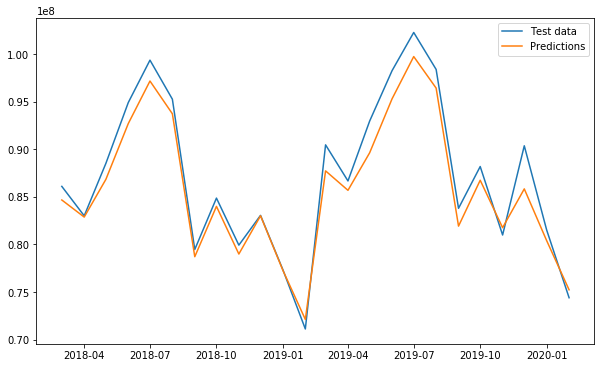

MSE on test:  3641675526727.0806
RMSE on test:  1908317.4596295767
RSS: 87400212641449.9531


In [51]:
test_model = sm.tsa.statespace.SARIMAX(train,order = (0,1,0),seasonal_order = (1,1,1,12),suppress_warnings=True)
test_result = test_model.fit()

test_forecast = test_result.predict(start = test.index[0], end = test.index[len(test)-1], dynamic = False)
plt.plot(test.Total,label='Test data')
plt.plot(test_forecast,label='Predictions')
plt.legend(loc='best')
plt.show()


from sklearn.metrics import mean_squared_error
print("MSE on test: ",mean_squared_error(test,test_forecast))
# calculating RMSE on test data
print("RMSE on test: ",np.sqrt(mean_squared_error(test,test_forecast)))

print('RSS: %.4f'%sum((test_forecast - test.Total )**2))

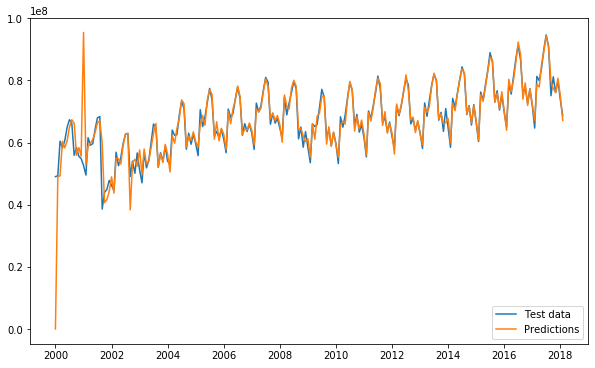

MSE on train:  26093841367930.72
RMSE on train:  5108213.128671387
RSS: 5688457418208895.0000


In [53]:
train_forecast = test_result.predict(start = train.index[0], end = train.index[len(train)-1], dynamic = False)
plt.plot(train.Total,label='Test data')
plt.plot(train_forecast,label='Predictions')
plt.legend(loc='best')
plt.show()


from sklearn.metrics import mean_squared_error
print("MSE on train: ",mean_squared_error(train,train_forecast))
# calculating RMSE on test data
print("RMSE on train: ",np.sqrt(mean_squared_error(train,train_forecast)))

print('RSS: %.4f'%sum((train_forecast - train.Total )**2))

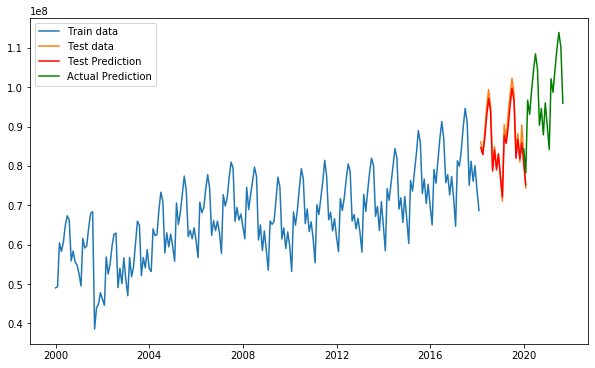

In [54]:
plt.plot(train,label='Train data')
plt.plot(test,label='Test data')
plt.plot(test_forecast,color = 'red',label = 'Test Prediction')
plt.plot(forecast,color = 'green',label='Actual Prediction')
plt.legend(loc='best')
plt.show()